In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("/usr/local/auryn/tools/python/"))
from auryntools import *

# Find low rank structure in spiking activity

In [44]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("../data/sim") # Set this to your data path
# datadir = os.path.expanduser("../data/sim_01-6_stim") # Set this to your data path
prefix = "rf1"

number_neurons = 4096
number_stimuli = 6
time_range = 100
bin_size = 100e-3

In [45]:
# Opens stim file
stimfile = np.loadtxt("%s/%s.0.stimtimes"%(datadir,prefix))
stimtime = np.zeros(len(stimfile))
stimdata = np.zeros((len(stimfile),number_stimuli))
for i,row in enumerate(stimfile):
    t,a,s = row
    stimtime[i] = t
    stimdata[i,int(s)] = a
    
# Opens spk output files
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

print("Crunching file ...")
tm = sfo.t_max 
t_start = tm-time_range
t_stop  = tm
data = sfo.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=number_neurons)

print("Analyzing ...")
nmf = NMF(n_components=number_stimuli)
nmf.fit(data)
y = nmf.transform(data)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Crunching file ...
Analyzing ...


Plotting ...


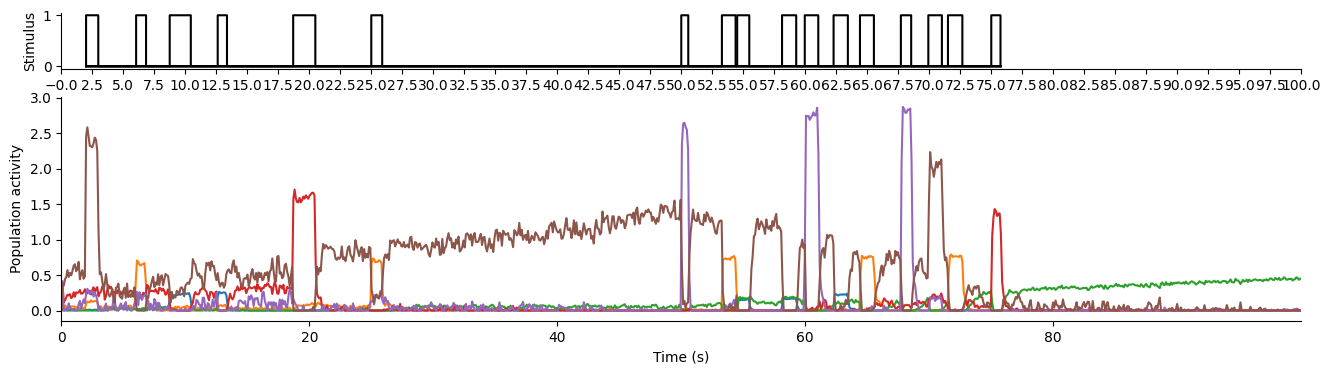

In [49]:
print("Plotting ...")
time = np.linspace(t_start,t_stop,data.shape[0])
gs = GridSpec(2,1,height_ratios=[1,4])
plt.figure(figsize=(16,4))
# plt.figure(figsize=(120,4))

ax = plt.subplot(gs[0])
# note that these colors might be out of order due to permutation invariance of NMF 
# which is why we make them black below
plt.plot(stimtime, stimdata, color="black")
plt.xlim((t_start,t_stop))
plt.xticks(np.arange(t_start, t_stop + 1, 2))
plt.xlabel("Time (s)")
plt.ylabel("Stimulus")
sns.despine()

ax = plt.subplot(gs[1])
plt.plot(time, y)
plt.xlim((t_start,t_stop))
plt.xlabel("Time (s)")
plt.ylabel("Population activity")
sns.despine()

In [13]:
# We can use these components to generate a new rf1.pat file for monitoring
# with open("rf1.pat","w") as f:
#     for comp in nmf.components_[order]:
#         for i,v in enumerate(comp):
#             if v<0.5: continue
#             f.write("%i\n"%i)
#         f.write("\n\n")

In [83]:
# stimtime.shape
# data.shape
for a, b in zip(stimtime, stimdata):
  print(a, b)

10.0 [0. 0. 0. 0. 0. 0.]
10.0001 [0. 0. 0. 0. 1. 0.]
10.9838 [0. 0. 0. 0. 1. 0.]
10.9839 [0. 0. 0. 0. 0. 0.]
14.0357 [0. 0. 0. 0. 0. 0.]
14.0358 [0. 0. 0. 1. 0. 0.]
14.8375 [0. 0. 0. 1. 0. 0.]
14.8376 [0. 0. 0. 0. 0. 0.]
16.744 [0. 0. 0. 0. 0. 0.]
16.7441 [0. 1. 0. 0. 0. 0.]
18.445 [0. 1. 0. 0. 0. 0.]
18.4451 [0. 0. 0. 0. 0. 0.]
20.6146 [0. 0. 0. 0. 0. 0.]
20.6147 [0. 1. 0. 0. 0. 0.]
21.3637 [0. 1. 0. 0. 0. 0.]
21.3638 [0. 0. 0. 0. 0. 0.]
26.7014 [0. 0. 0. 0. 0. 0.]
26.7015 [0. 0. 1. 0. 0. 0.]
28.4872 [0. 0. 1. 0. 0. 0.]
28.4873 [0. 0. 0. 0. 0. 0.]


# Load and analyze EE weights

In [40]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )
w = w.todense()

Text(0.5, 1.0, 'Weight matrix')

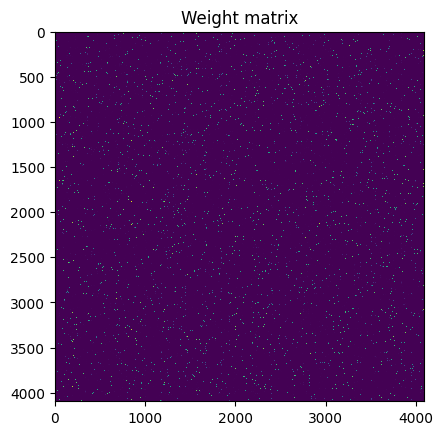

In [42]:
plt.imshow(w,interpolation="none",cmap="viridis")
plt.title("Weight matrix")

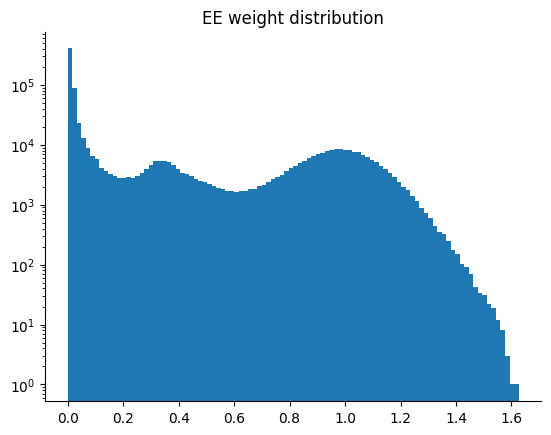

In [9]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()

In [10]:
# Now let's find the cell assemblies
nmf = NMF(n_components=4)
wy = nmf.fit_transform(w)

In [11]:
wy.shape

(4096, 4)

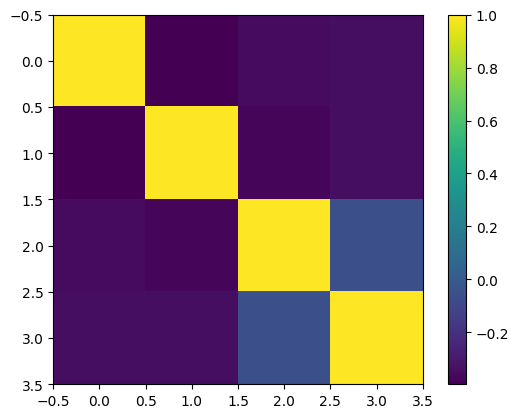

In [12]:
plt.imshow(np.corrcoef(nmf.components_))
plt.colorbar()